TAREA: Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.

In [2]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt

6
Area: 3365.5, Perímetro: 223.72286927700043, Circularidad: 0.8449649566287991, Relación perimetro circulo: 1.0565387043350678
Area: 5521.0, Perímetro: 285.7644993066788, Circularidad: 0.8495932648321268, Relación perimetro circulo: 1.0474298504834676
Area: 5254.0, Perímetro: 272.5929274559021, Circularidad: 0.888527277625479, Relación perimetro circulo: 1.041250655175479
Area: 3218.5, Perímetro: 217.72286880016327, Circularidad: 0.853208711875944, Relación perimetro circulo: 1.0280884110727408
Area: 5155.0, Perímetro: 270.59292781352997, Circularidad: 0.8847196029864544, Relación perimetro circulo: 1.039292397029201
Area: 5645.0, Perímetro: 308.5340510606766, Circularidad: 0.7451910106168876, Relación perimetro circulo: 1.1185443947611664
Area: 5066.0, Perímetro: 266.93607234954834, Circularidad: 0.8934299713344522, Relación perimetro circulo: 1.0363169422377843
Area: 6172.0, Perímetro: 298.73506128787994, Circularidad: 0.8690872678779692, Relación perimetro circulo: 1.03991353936853

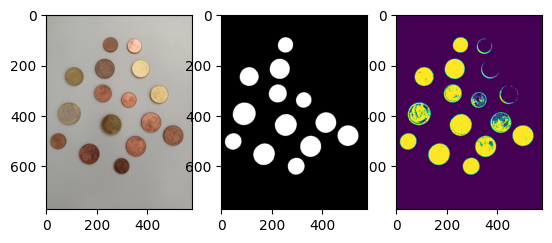

In [87]:
img = cv2.imread('./Assets/EvenlyScattered.jpg')
if img.shape[1] > 800:
    factor_reduccion = img.shape[1]//500
    img = cv2.resize(img, (img.shape[1]//factor_reduccion,img.shape[0]//factor_reduccion))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

umbral = 200

th1,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
th2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

contornos2, hierarchy2 = cv2.findContours(img_th2, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)
#cv2.drawContours(img, contornos2, -1, (0,255,0), 3)

img_cont = np.zeros(img_rgb.shape, dtype=np.uint8)
#Recorre los contornos externos
for c in contornos2:
    #Área del contorno
    area = cv2.contourArea(c)
    #Área mínima (útil filtrar en ocasiones)
    if area > 10:
        #Perímetro del contorno
        perimetro = cv2.arcLength(c,True)
        #Contenedor alineado con ejes de la imagen
        x,y,w,h = cv2.boundingRect(c)
        #Mínimo contenedor ajustado para el contorno
        (cx,cy),radio = cv2.minEnclosingCircle(c)
        
        #cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)
        #print(f'Area: {area}, Perímetro: {perimetro}, Circularidad: {circularidad}, Relación perimetro circulo: {relacion_perimetro_circulo}')
            

        circularidad = 4*np.pi*area/(perimetro*perimetro)
        relacion_perimetro_circulo = perimetro/(2*np.pi*radio)

        if  0.5 < circularidad < 1.1 and 1 < relacion_perimetro_circulo < 1.5:
            cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)
            print(f'Area: {area}, Perímetro: {perimetro}, Circularidad: {circularidad}, Relación perimetro circulo: {relacion_perimetro_circulo}')

#Hough

# Convertir la imagen de contornos a escala de grises para usar con HoughCircles
img_cont_gris = cv2.cvtColor(img_cont, cv2.COLOR_RGB2GRAY)

# Aplicar un desenfoque a img_cont_gris para reducir ruido
img_cont_blur = cv2.GaussianBlur(img_cont_gris, (9, 9), 3)

circles = cv2.HoughCircles(
    img_cont_blur, 
    cv2.HOUGH_GRADIENT, 
    dp=1, 
    minDist=30, 
    param1=150, 
    param2=50, 
    minRadius=0, 
    maxRadius=150
)
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        print(i)
        center = (i[0], i[1])
        # Dibujar el círculo externo
        cv2.circle(img, (i[0], i[1]), i[2], (0, 255, 0), 2)
    

plt.subplot(1, 3, 1)
plt.imshow(img_rgb)

plt.subplot(1, 3, 2)
plt.imshow(img_cont)    

plt.subplot(1, 3, 3)
plt.imshow(img_th2)

windowName = "amor"

cv2.namedWindow(windowName)
def on_mouse(event, x, y, flags, userdata):
    if event == cv2.EVENT_LBUTTONDOWN and isCoin(x,y, img_cont):
        print(f'Mouse position: ({x}, {y})')

def isCoin(x, y, img):
    return (0 != np.sum(img[y,x]))

cv2.setMouseCallback(windowName, on_mouse)

cv2.imshow(windowName,img)
cv2.waitKey(-1) # Se detiene hasta pulsar tecla (>0 milisegundos)
cv2.destroyAllWindows() # Destruye todas las ventanas